# Counterfactual Explanations POC - House Prices

This notebook demonstrates how to use DiCE-ML for generating counterfactual explanations in regression problems using the House Prices dataset. We'll show how to explain model predictions and suggest actionable changes to achieve desired house prices.

## 1. Settings

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from feature_engine.selection import DropFeatures, DropConstantFeatures
from feature_engine.imputation import ArbitraryNumberImputer, CategoricalImputer
from feature_engine.encoding import CountFrequencyEncoder

# Modelling
import lightgbm as lgb
from sklearn.feature_selection import RFECV
import optuna

import shap
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# Counterfactuals
import dice_ml

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 2. Data Loading and Exploration

In [2]:
# Load the data
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

Training data shape: (1460, 81)
Test data shape: (1459, 80)


In [3]:
# Display basic information about the dataset
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
# Display summary statistics
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [5]:
train_df['SalePrice'].describe([0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
1%        61815.970000
5%        88000.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
95%      326100.000000
99%      442567.010000
max      755000.000000
Name: SalePrice, dtype: float64

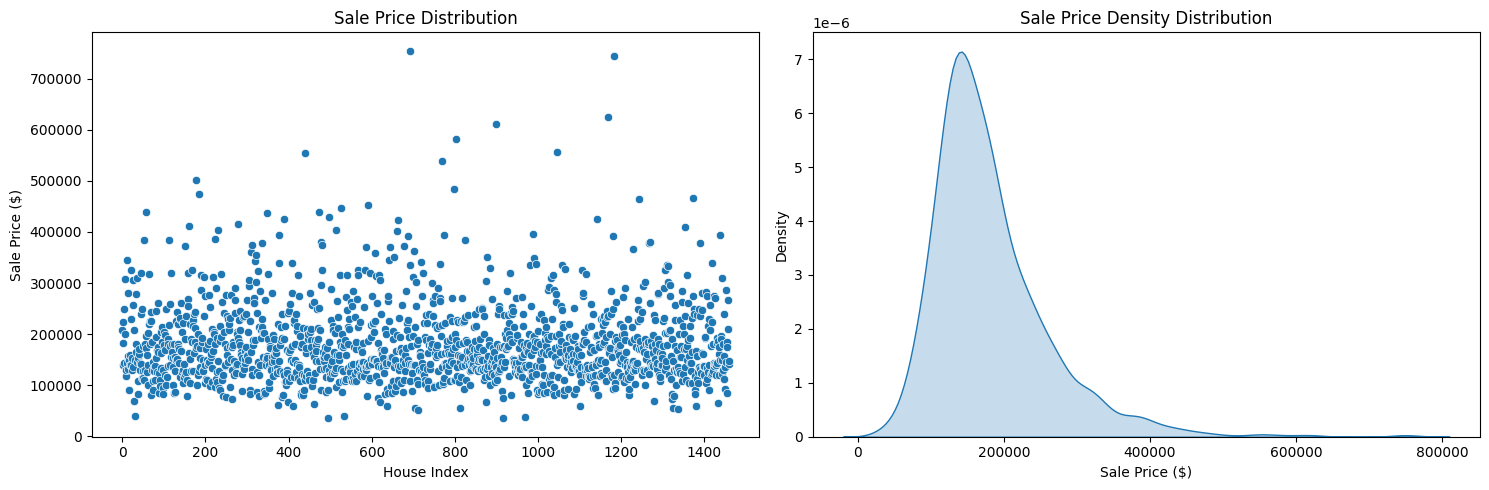

In [6]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Scatter plot of SalePrice
sns.scatterplot(data=train_df, x=train_df.index, y='SalePrice', ax=ax1)
ax1.set_title('Sale Price Distribution')
ax1.set_xlabel('House Index')
ax1.set_ylabel('Sale Price ($)')

# Density plot of SalePrice
sns.kdeplot(data=train_df['SalePrice'], ax=ax2, fill=True)
ax2.set_title('Sale Price Density Distribution')
ax2.set_xlabel('Sale Price ($)')
ax2.set_ylabel('Density')

plt.tight_layout()
plt.show()

In [7]:
# Check for missing values and calculate percentages
missing_values = train_df.isnull().sum()
missing_percentages = (missing_values / len(train_df)) * 100
missing_info = pd.DataFrame({
    'Missing Values': missing_values[missing_values > 0],
    'Percentage': missing_percentages[missing_values > 0]
})
missing_info.sort_values('Missing Values', ascending=False)

,Missing Values,Percentage
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945
GarageQual,81,5.547945


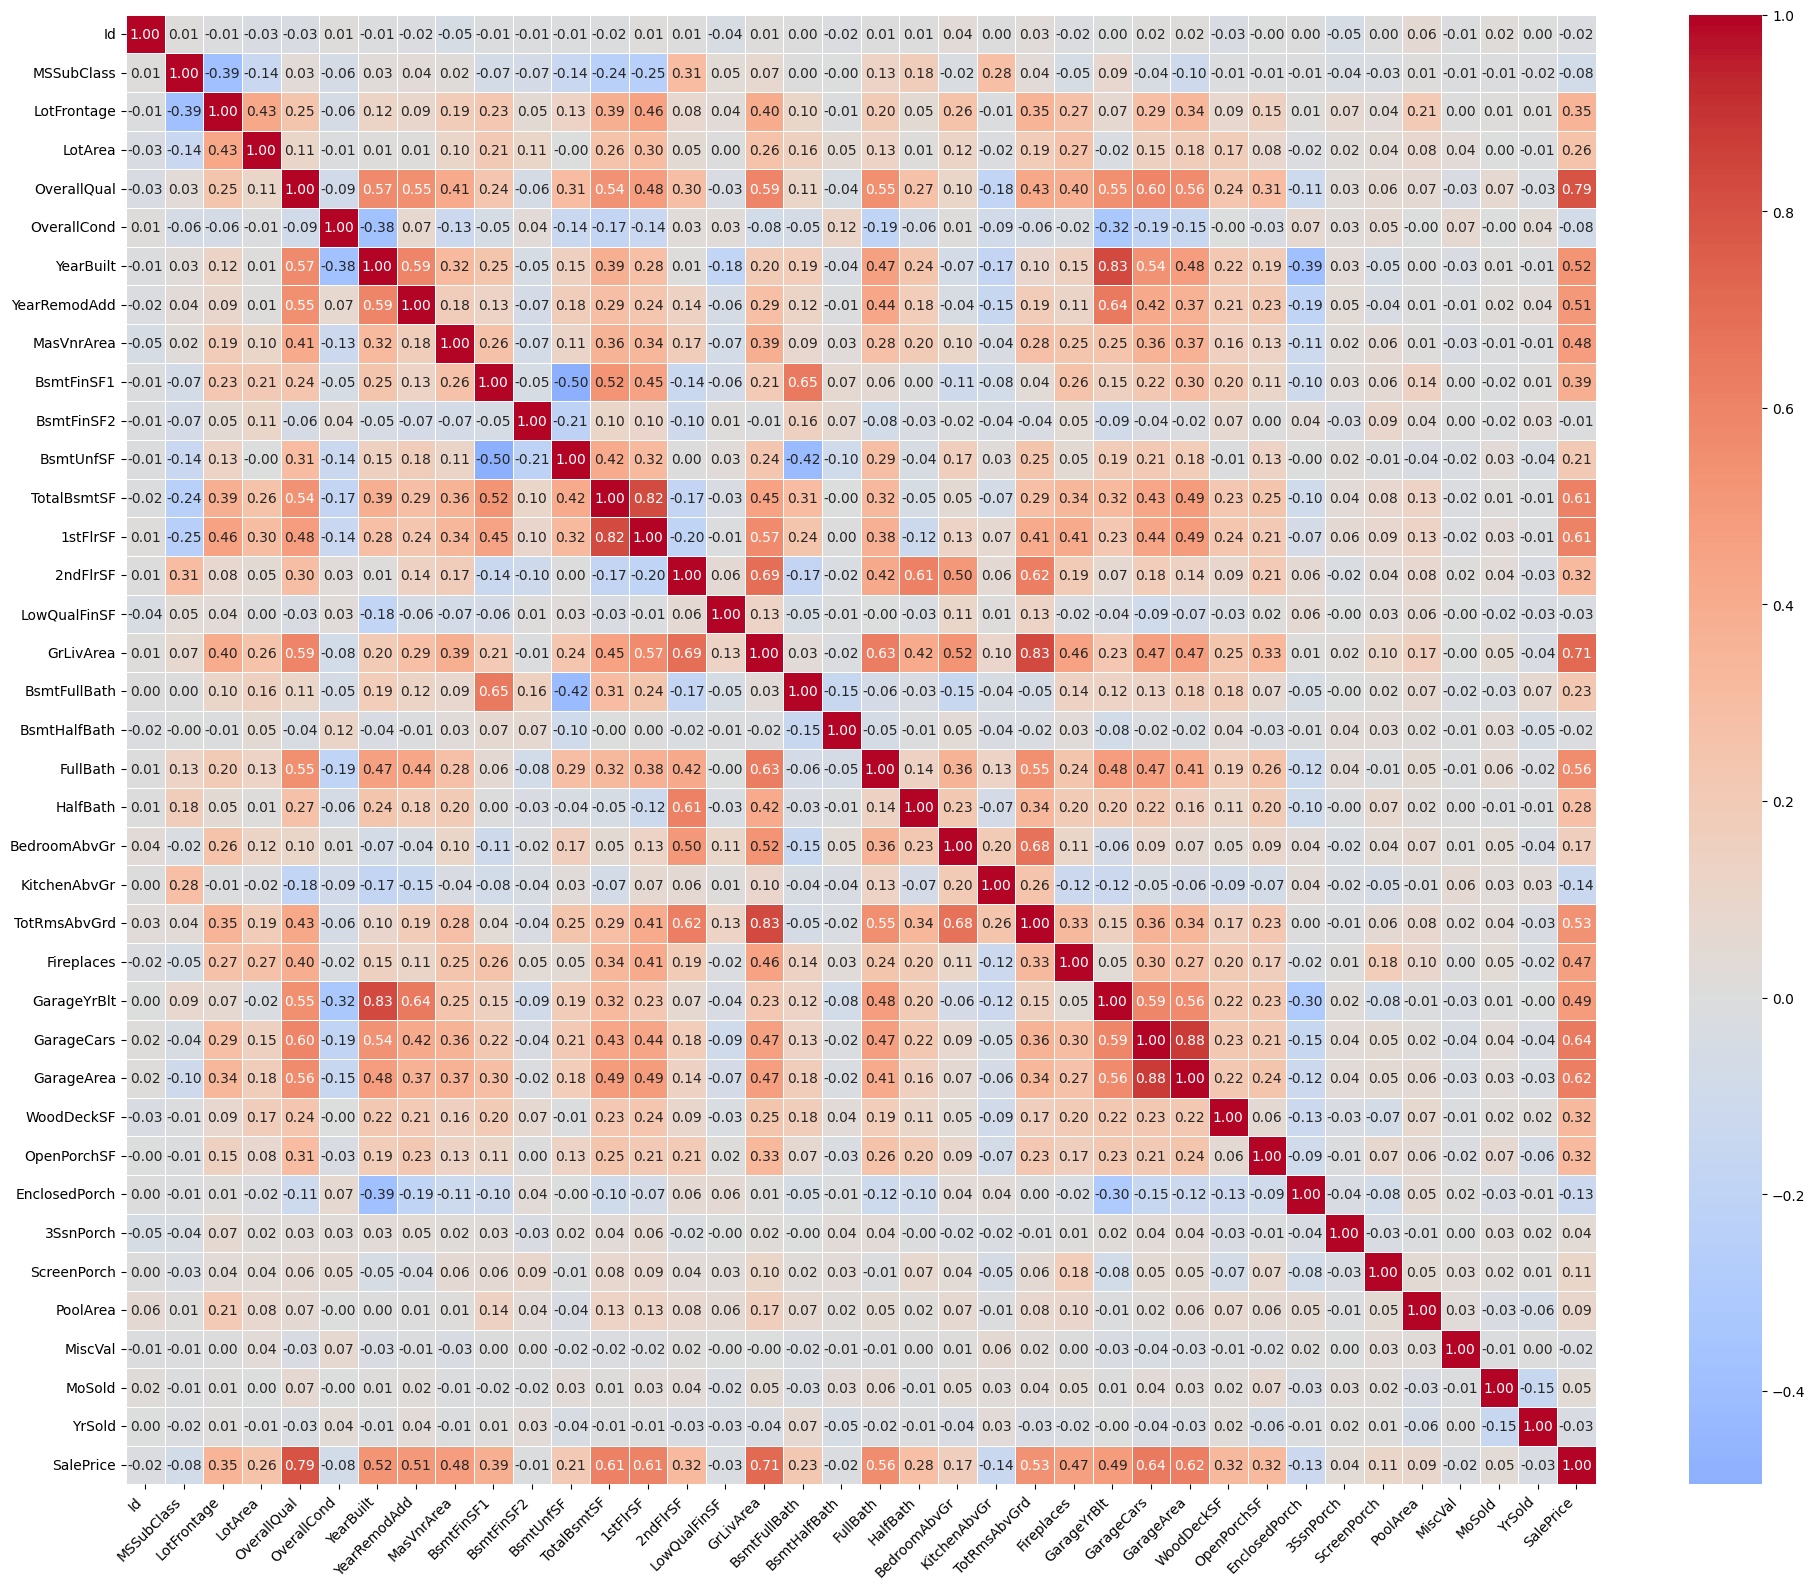


Top 10 features most correlated with SalePrice:
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64


In [8]:
# Calculate correlation matrix for numerical features
correlation_matrix = train_df.corr()

# Create a figure with a larger size
plt.figure(figsize=(20, 16))

# Create heatmap
sns.heatmap(correlation_matrix, 
            annot=True,  # Show correlation values
            cmap='coolwarm',  # Color scheme
            center=0,  # Center the colormap at 0
            fmt='.2f',  # Format correlation values to 2 decimal places
            square=True,  # Make the plot square
            linewidths=0.5)  # Add lines between cells

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

# Print top correlations with SalePrice
print("\nTop 10 features most correlated with SalePrice:")
price_correlations = correlation_matrix['SalePrice'].sort_values(ascending=False)
print(price_correlations[1:11])  # Skip first one as it's SalePrice itself


## 3. Feature Engineering and Preprocessing

In [9]:
# Define target variable
TARGET = 'SalePrice'

# Separate features and target
X = train_df.drop([TARGET, 'Id'], axis=1)
y = train_df[TARGET]

# Split the data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {x_train.shape}")
print(f"Test set shape: {x_test.shape}")

Training set shape: (1168, 79)
Test set shape: (292, 79)


In [10]:
NULL_COLS = [
    "PoolQC",
    "MiscFeature",
    "Alley",
    "Fence",
]

# 1. Drop columns with 80% missing values
drop_missing_cols_obj = DropFeatures(features_to_drop=NULL_COLS)

# Apply the transformation
x_train = drop_missing_cols_obj.fit_transform(x_train)
x_test = drop_missing_cols_obj.transform(x_test)

In [11]:
# 2. Impute missing values
fill_with_zero_cols = [
    'LotFrontage', 
    'GarageYrBlt',
    'MasVnrArea',
]

# Impute missing values with 0 for specified columns (works only with numerical)
arbitrary_imputer_minus_one_obj = ArbitraryNumberImputer(arbitrary_number=0, variables=fill_with_zero_cols)

# Apply the transformation
x_train = arbitrary_imputer_minus_one_obj.fit_transform(x_train)
x_test = arbitrary_imputer_minus_one_obj.transform(x_test)

In [12]:
# 3. Categorical imputation with "missing"
CATEGORICAL_COLS = [
    'GarageType',
    'GarageFinish',
    'GarageQual',
    'GarageCond',
    'BsmtExposure',
    'BsmtFinType2',
    'BsmtFinType1',
    'BsmtCond', 
    'BsmtQual',
    'MasVnrType',
    'Electrical',
    'FireplaceQu',
]
categorical_imputer_obj = CategoricalImputer(
    imputation_method="missing", fill_value="missing", variables=CATEGORICAL_COLS
    )

# Apply the transformation
x_train = categorical_imputer_obj.fit_transform(x_train)
x_test = categorical_imputer_obj.transform(x_test)

In [13]:
# Initialize the drop constant features selector
drop_constant_features = DropConstantFeatures(
    variables=None,  # Will check all features
    tol=0.9,  # Drop features that show the same value in 90% of the observations
    missing_values='raise',
    confirm_variables=False
)

# Apply the transformation
x_train = drop_constant_features.fit_transform(x_train)
x_test = drop_constant_features.transform(x_test)


In [14]:
# Initialize the count frequency encoder
count_freq_encoder = CountFrequencyEncoder(
    encoding_method='count',
    variables=None,  # Will encode all categorical variables
    missing_values='raise',
    unseen='ignore'
)

# Apply the transformation
x_train = count_freq_encoder.fit_transform(x_train)
x_test = count_freq_encoder.transform(x_test)

In [15]:
# Ensure no missing values are left.
x_train.isnull().sum().sum(), x_test.isnull().sum().sum()

(0, 0)

# 3. Feature Selection

In [16]:
# Initialize base estimator for RFECV
base_estimator = lgb.LGBMRegressor(
    random_state=42
)

# Fit the recursive feature elimination
rfecv = RFECV(
    estimator=base_estimator,
    step=1,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
rfecv.fit(x_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002922 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002906 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2853
[LightGBM] [Info] Total Bins 2844
[LightGBM] [Info] Total Bins

RFECV(cv=5, estimator=LGBMRegressor(random_state=42), n_jobs=-1,
      scoring='neg_mean_squared_error')

In [17]:
# Get selected features
selected_features = x_train.columns[rfecv.support_].tolist()
print(f"\nNumber of selected features: {len(selected_features)}")
print("\nSelected features:")
print(selected_features)


Number of selected features: 45

Selected features:
['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape', 'LotConfig', 'Neighborhood', 'Condition1', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'Exterior1st', 'Exterior2nd', 'MasVnrArea', 'ExterQual', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'MoSold', 'YrSold', 'SaleCondition']


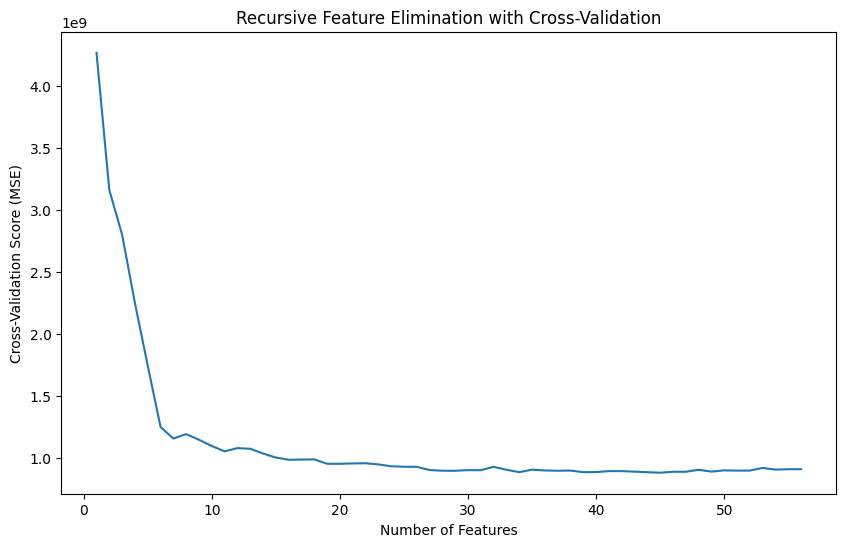

In [18]:
# Plot number of features vs cross-validation score
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), -rfecv.cv_results_['mean_test_score'])
plt.xlabel('Number of Features')
plt.ylabel('Cross-Validation Score (MSE)')
plt.title('Recursive Feature Elimination with Cross-Validation')
plt.show()

In [19]:
# Update processed datasets with selected features
x_train_processed = x_train[selected_features]
x_test_processed = x_test[selected_features]

# 4. Hyperparameter Tuning

In [23]:
# Define the objective function for Optuna
def objective(trial):
    # Define hyperparameter search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True)
    }
    
    # Create and train model
    model = lgb.LGBMRegressor(**params, random_state=42)
    model.fit(x_train_processed, y_train)
    
    # Make predictions and calculate RMSE
    preds = model.predict(x_test_processed)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    
    return rmse

# Create Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Print best parameters and score
print("\nBest parameters:", study.best_params)
print("Best RMSE:", study.best_value)

[I 2025-05-18 19:26:41,418] A new study created in memory with name: no-name-48f4e7c9-3c4b-438d-a389-ba3866f4593e


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 45
[LightGBM] [Info] Start training from score 181441.541952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-05-18 19:26:42,590] Trial 0 finished with value: 33540.897236277626 and parameters: {'n_estimators': 931, 'learning_rate': 0.15799075858026193, 'max_depth': 4, 'num_leaves': 53, 'min_child_samples': 97, 'subsample': 0.7803956169691416, 'colsample_bytree': 0.8265784523250265, 'reg_alpha': 0.00036436171537701105, 'reg_lambda': 0.17756254378791383}. Best is trial 0 with value: 33540.897236277626.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 19:26:43,769] Trial 1 finished with value: 25391.461855118214 and parameters: {'n_estimators': 282, 'learning_rate': 0.03652068309476725, 'max_depth': 11, 'num_leaves': 22, 'min_child_samples': 10, 'subsample': 0.7329638059972388, 'colsample_bytree': 0.675102109066321, 'reg_alpha': 0.00023007397834358273, 'reg_lambda': 0.0003655805108546722}. Best is trial 1 with value: 25391.461855118214.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 45
[LightGBM] [Info] Start training from score 181441.541952
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-05-18 19:26:44,502] Trial 2 finished with value: 34293.594777340186 and parameters: {'n_estimators': 587, 'learning_rate': 0.016362768962020862, 'max_depth': 3, 'num_leaves': 26, 'min_child_samples': 92, 'subsample': 0.6836578282923415, 'colsample_bytree': 0.7421667960393921, 'reg_alpha': 0.032183166881400244, 'reg_lambda': 7.4720287755494555e-06}. Best is trial 1 with value: 25391.461855118214.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 19:26:46,721] Trial 3 finished with value: 31392.099013975734 and parameters: {'n_estimators': 930, 'learning_rate': 0.25259861620377744, 'max_depth': 9, 'num_leaves': 83, 'min_child_samples': 69, 'subsample': 0.7192211061259429, 'colsample_bytree': 0.7679487617033592, 'reg_alpha': 0.006004883337095815, 'reg_lambda': 0.0002427551050482087}. Best is trial 1 with value: 25391.461855118214.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-ch

[I 2025-05-18 19:26:47,565] Trial 4 finished with value: 31812.903558615148 and parameters: {'n_estimators': 616, 'learning_rate': 0.01246610928955711, 'max_depth': 4, 'num_leaves': 70, 'min_child_samples': 48, 'subsample': 0.620386427482049, 'colsample_bytree': 0.9579952598483797, 'reg_alpha': 0.0028788093964675797, 'reg_lambda': 2.0493729354047407}. Best is trial 1 with value: 25391.461855118214.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 19:26:48,589] Trial 5 finished with value: 32375.81728196521 and parameters: {'n_estimators': 733, 'learning_rate': 0.27078173024308055, 'max_depth': 4, 'num_leaves': 70, 'min_child_samples': 52, 'subsample': 0.6053211072251078, 'colsample_bytree': 0.832984755719829, 'reg_alpha': 0.012473322726042594, 'reg_lambda': 0.2245744236781272}. Best is trial 1 with value: 25391.461855118214.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 19:26:50,628] Trial 6 finished with value: 31395.4284314837 and parameters: {'n_estimators': 934, 'learning_rate': 0.05365895265148506, 'max_depth': 10, 'num_leaves': 25, 'min_child_samples': 76, 'subsample': 0.7582579985798062, 'colsample_bytree': 0.6693808583444657, 'reg_alpha': 0.00040530262528210015, 'reg_lambda': 2.2797472544743836e-05}. Best is trial 1 with value: 25391.461855118214.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 19:26:51,525] Trial 7 finished with value: 37210.825730468154 and parameters: {'n_estimators': 452, 'learning_rate': 0.010991669098720522, 'max_depth': 12, 'num_leaves': 73, 'min_child_samples': 84, 'subsample': 0.9613262830457179, 'colsample_bytree': 0.9393960677526907, 'reg_alpha': 0.002367053899005214, 'reg_lambda': 8.78016014122917e-08}. Best is trial 1 with value: 25391.461855118214.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000662 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 45
[LightGBM] [Info] Start training from score 181441.541952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-05-18 19:26:52,108] Trial 8 finished with value: 28017.33707742413 and parameters: {'n_estimators': 497, 'learning_rate': 0.017324590532509863, 'max_depth': 3, 'num_leaves': 26, 'min_child_samples': 15, 'subsample': 0.7375740038212832, 'colsample_bytree': 0.7314670202951632, 'reg_alpha': 0.0006226724211007301, 'reg_lambda': 1.715644019357045e-07}. Best is trial 1 with value: 25391.461855118214.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 19:26:52,508] Trial 9 finished with value: 29430.105753446067 and parameters: {'n_estimators': 239, 'learning_rate': 0.03367970120155668, 'max_depth': 4, 'num_leaves': 53, 'min_child_samples': 23, 'subsample': 0.6372120760409871, 'colsample_bytree': 0.8064726482657755, 'reg_alpha': 0.0033692139026851448, 'reg_lambda': 0.007750854933410633}. Best is trial 1 with value: 25391.461855118214.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 19:26:53,093] Trial 10 finished with value: 25363.851703770044 and parameters: {'n_estimators': 133, 'learning_rate': 0.09255610596114168, 'max_depth': 7, 'num_leaves': 40, 'min_child_samples': 5, 'subsample': 0.8743033462653452, 'colsample_bytree': 0.6264848158395016, 'reg_alpha': 4.648717102813814e-07, 'reg_lambda': 0.0022993725013749407}. Best is trial 10 with value: 25363.851703770044.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 19:26:53,504] Trial 11 finished with value: 26083.083790945777 and parameters: {'n_estimators': 102, 'learning_rate': 0.10932729906784239, 'max_depth': 7, 'num_leaves': 37, 'min_child_samples': 9, 'subsample': 0.887970474905599, 'colsample_bytree': 0.6044018431420954, 'reg_alpha': 1.9443229225151164e-07, 'reg_lambda': 0.0037997838352250403}. Best is trial 10 with value: 25363.851703770044.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 45
[LightGBM] [Info] Start training from score 181441.541952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-05-18 19:26:54,410] Trial 12 finished with value: 27423.25760933049 and parameters: {'n_estimators': 293, 'learning_rate': 0.07040790765251186, 'max_depth': 7, 'num_leaves': 42, 'min_child_samples': 31, 'subsample': 0.8648126093170577, 'colsample_bytree': 0.6137610940505533, 'reg_alpha': 8.936248069306461e-07, 'reg_lambda': 0.0024498832752277897}. Best is trial 10 with value: 25363.851703770044.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 19:26:54,876] Trial 13 finished with value: 32687.854164513323 and parameters: {'n_estimators': 108, 'learning_rate': 0.03232924653945846, 'max_depth': 12, 'num_leaves': 39, 'min_child_samples': 34, 'subsample': 0.8487667684871838, 'colsample_bytree': 0.6646379077575957, 'reg_alpha': 1.7118106448180666, 'reg_lambda': 3.0982117336460144e-05}. Best is trial 10 with value: 25363.851703770044.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 19:26:56,405] Trial 14 finished with value: 25235.434560571444 and parameters: {'n_estimators': 319, 'learning_rate': 0.06453722564115394, 'max_depth': 9, 'num_leaves': 20, 'min_child_samples': 5, 'subsample': 0.9307131519585253, 'colsample_bytree': 0.6681080232743485, 'reg_alpha': 6.36734507924989e-06, 'reg_lambda': 0.0003450241471182986}. Best is trial 14 with value: 25235.434560571444.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 45
[LightGBM] [Info] Start training from score 181441.541952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-05-18 19:26:58,502] Trial 15 finished with value: 23169.30453616584 and parameters: {'n_estimators': 386, 'learning_rate': 0.09792004507371943, 'max_depth': 8, 'num_leaves': 47, 'min_child_samples': 5, 'subsample': 0.9992827722895632, 'colsample_bytree': 0.6867105351848235, 'reg_alpha': 4.67806327511065e-06, 'reg_lambda': 0.03133989554140809}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 45
[LightGBM] [Info] Start training from score 181441.541952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-05-18 19:26:59,484] Trial 16 finished with value: 28984.47993676382 and parameters: {'n_estimators': 379, 'learning_rate': 0.1434311661629247, 'max_depth': 9, 'num_leaves': 93, 'min_child_samples': 38, 'subsample': 0.9930337512435561, 'colsample_bytree': 0.8773056658946138, 'reg_alpha': 8.394775472404926e-06, 'reg_lambda': 0.03132164383065688}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 19:27:00,629] Trial 17 finished with value: 28955.923015784676 and parameters: {'n_estimators': 402, 'learning_rate': 0.05499824368752264, 'max_depth': 8, 'num_leaves': 54, 'min_child_samples': 22, 'subsample': 0.9320906385588, 'colsample_bytree': 0.704010880046852, 'reg_alpha': 1.9911320775086718e-08, 'reg_lambda': 3.8463407049135125}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 19:27:02,419] Trial 18 finished with value: 30283.17579859303 and parameters: {'n_estimators': 704, 'learning_rate': 0.16191511841234887, 'max_depth': 6, 'num_leaves': 100, 'min_child_samples': 21, 'subsample': 0.9985888522426906, 'colsample_bytree': 0.7714952021541797, 'reg_alpha': 1.612638303506866e-05, 'reg_lambda': 5.548494916929692e-07}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 19:27:02,988] Trial 19 finished with value: 31381.933434034552 and parameters: {'n_estimators': 234, 'learning_rate': 0.07996099733921481, 'max_depth': 9, 'num_leaves': 61, 'min_child_samples': 67, 'subsample': 0.9367119950322573, 'colsample_bytree': 0.698861483771824, 'reg_alpha': 2.8224248045907096e-05, 'reg_lambda': 2.461266029310141e-06}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 19:27:03,727] Trial 20 finished with value: 28617.748792760503 and parameters: {'n_estimators': 369, 'learning_rate': 0.05593449677911948, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 39, 'subsample': 0.8241080618529704, 'colsample_bytree': 0.650271055686322, 'reg_alpha': 1.4374784002377695e-08, 'reg_lambda': 1.5521838203682128e-08}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 45
[LightGBM] [Info] Start training from score 181441.541952
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-05-18 19:27:05,034] Trial 21 finished with value: 25003.196267792322 and parameters: {'n_estimators': 180, 'learning_rate': 0.11658112167371325, 'max_depth': 8, 'num_leaves': 45, 'min_child_samples': 6, 'subsample': 0.90284882616836, 'colsample_bytree': 0.610437201721027, 'reg_alpha': 5.278349908905781e-07, 'reg_lambda': 0.0003267872872167266}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 45
[LightGBM] [Info] Start training from score 181441.541952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-05-18 19:27:05,827] Trial 22 finished with value: 28192.22462589051 and parameters: {'n_estimators': 195, 'learning_rate': 0.19497908990002039, 'max_depth': 8, 'num_leaves': 48, 'min_child_samples': 17, 'subsample': 0.9092323157811284, 'colsample_bytree': 0.6360239042568351, 'reg_alpha': 2.7013225446989618e-06, 'reg_lambda': 0.00010824652146441266}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 45
[LightGBM] [Info] Start training from score 181441.541952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-05-18 19:27:07,653] Trial 23 finished with value: 26081.18562518993 and parameters: {'n_estimators': 330, 'learning_rate': 0.11269906015519704, 'max_depth': 10, 'num_leaves': 35, 'min_child_samples': 7, 'subsample': 0.9546861604131752, 'colsample_bytree': 0.72195933804463, 'reg_alpha': 6.724464508019074e-08, 'reg_lambda': 0.033195476565760114}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 45
[LightGBM] [Info] Start training from score 1814

[I 2025-05-18 19:27:09,279] Trial 24 finished with value: 27907.833961898115 and parameters: {'n_estimators': 494, 'learning_rate': 0.11287625193441737, 'max_depth': 10, 'num_leaves': 46, 'min_child_samples': 28, 'subsample': 0.9083154688626237, 'colsample_bytree': 0.688123739891711, 'reg_alpha': 5.092319539104495e-05, 'reg_lambda': 0.0005687618932543428}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 19:27:09,919] Trial 25 finished with value: 27271.385648678348 and parameters: {'n_estimators': 199, 'learning_rate': 0.0426861163194921, 'max_depth': 6, 'num_leaves': 60, 'min_child_samples': 15, 'subsample': 0.9802571992363021, 'colsample_bytree': 0.6036444574868648, 'reg_alpha': 9.8280044034874e-07, 'reg_lambda': 0.019319626739707062}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 19:27:12,080] Trial 26 finished with value: 24314.022745841274 and parameters: {'n_estimators': 439, 'learning_rate': 0.024349270141629634, 'max_depth': 8, 'num_leaves': 33, 'min_child_samples': 5, 'subsample': 0.8325739342731308, 'colsample_bytree': 0.6486095649178508, 'reg_alpha': 4.972079734562307e-06, 'reg_lambda': 0.20990256867950666}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 19:27:13,324] Trial 27 finished with value: 30182.108764810062 and parameters: {'n_estimators': 458, 'learning_rate': 0.01820430157411954, 'max_depth': 8, 'num_leaves': 32, 'min_child_samples': 44, 'subsample': 0.8289812053072945, 'colsample_bytree': 0.6495790110944833, 'reg_alpha': 1.3886536193669184e-07, 'reg_lambda': 0.2876545955238462}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 19:27:14,422] Trial 28 finished with value: 30583.009290647675 and parameters: {'n_estimators': 641, 'learning_rate': 0.02831441139939161, 'max_depth': 5, 'num_leaves': 47, 'min_child_samples': 58, 'subsample': 0.8056345425093907, 'colsample_bytree': 0.8725899418922163, 'reg_alpha': 1.4227047932671782e-06, 'reg_lambda': 1.0102087021139228}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 19:27:16,092] Trial 29 finished with value: 29053.23155722458 and parameters: {'n_estimators': 546, 'learning_rate': 0.024185304958694046, 'max_depth': 8, 'num_leaves': 62, 'min_child_samples': 27, 'subsample': 0.7735021715214034, 'colsample_bytree': 0.7635112808510375, 'reg_alpha': 7.556507061955498e-05, 'reg_lambda': 9.064082669355361}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 19:27:17,455] Trial 30 finished with value: 26994.959566518155 and parameters: {'n_estimators': 410, 'learning_rate': 0.1510136718676903, 'max_depth': 7, 'num_leaves': 44, 'min_child_samples': 14, 'subsample': 0.8979986626597383, 'colsample_bytree': 0.6358897729717051, 'reg_alpha': 4.336715188869647e-06, 'reg_lambda': 0.12871518333633922}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 45
[LightGBM] [Info] Start training from score 181441.541952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-05-18 19:27:18,697] Trial 31 finished with value: 25154.738374411172 and parameters: {'n_estimators': 320, 'learning_rate': 0.070936989048312, 'max_depth': 9, 'num_leaves': 21, 'min_child_samples': 6, 'subsample': 0.9343866938237803, 'colsample_bytree': 0.7053269300307415, 'reg_alpha': 8.869626288788675e-06, 'reg_lambda': 0.09028925720930787}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000696 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 45
[LightGBM] [Info] Start training from score 181441.541952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-05-18 19:27:19,480] Trial 32 finished with value: 27639.84801555336 and parameters: {'n_estimators': 182, 'learning_rate': 0.08927741556540975, 'max_depth': 11, 'num_leaves': 30, 'min_child_samples': 12, 'subsample': 0.9654649477472304, 'colsample_bytree': 0.7034762287293116, 'reg_alpha': 8.888150113939626e-05, 'reg_lambda': 0.5598119671017587}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 19:27:20,700] Trial 33 finished with value: 28174.03054076866 and parameters: {'n_estimators': 285, 'learning_rate': 0.04005374759571598, 'max_depth': 9, 'num_leaves': 34, 'min_child_samples': 20, 'subsample': 0.8539098931283172, 'colsample_bytree': 0.7193807345485191, 'reg_alpha': 2.572940518830851e-07, 'reg_lambda': 0.07701746002385054}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 19:27:22,795] Trial 34 finished with value: 26369.84511173127 and parameters: {'n_estimators': 347, 'learning_rate': 0.20548812864754684, 'max_depth': 8, 'num_leaves': 55, 'min_child_samples': 5, 'subsample': 0.9225518956938551, 'colsample_bytree': 0.7455863559230016, 'reg_alpha': 4.067843368889429e-08, 'reg_lambda': 0.008957319566675025}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 1168, n

[I 2025-05-18 19:27:23,315] Trial 35 finished with value: 34826.89762915048 and parameters: {'n_estimators': 258, 'learning_rate': 0.04685164467214904, 'max_depth': 10, 'num_leaves': 23, 'min_child_samples': 100, 'subsample': 0.97020481126597, 'colsample_bytree': 0.679107190638129, 'reg_alpha': 1.703713353119795e-05, 'reg_lambda': 0.05911347167806439}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 19:27:25,519] Trial 36 finished with value: 26346.801974742088 and parameters: {'n_estimators': 571, 'learning_rate': 0.07927691099137739, 'max_depth': 9, 'num_leaves': 29, 'min_child_samples': 10, 'subsample': 0.9442714791393411, 'colsample_bytree': 0.6487719261498518, 'reg_alpha': 0.5706350204614671, 'reg_lambda': 0.001029584520128655}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory

[I 2025-05-18 19:27:26,847] Trial 37 finished with value: 27008.884457527434 and parameters: {'n_estimators': 428, 'learning_rate': 0.12675978280674827, 'max_depth': 7, 'num_leaves': 37, 'min_child_samples': 11, 'subsample': 0.8850896264493473, 'colsample_bytree': 0.6264667072619426, 'reg_alpha': 0.00022489366504478505, 'reg_lambda': 1.217347034331246}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 19:27:30,588] Trial 38 finished with value: 28614.193396048475 and parameters: {'n_estimators': 851, 'learning_rate': 0.020672291695352646, 'max_depth': 11, 'num_leaves': 50, 'min_child_samples': 18, 'subsample': 0.8346419593834878, 'colsample_bytree': 0.7983479677036911, 'reg_alpha': 4.1398421830918116e-06, 'reg_lambda': 9.586156921700714e-05}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 19:27:32,352] Trial 39 finished with value: 29977.922567550675 and parameters: {'n_estimators': 520, 'learning_rate': 0.013882318210114252, 'max_depth': 8, 'num_leaves': 24, 'min_child_samples': 28, 'subsample': 0.7941876186617323, 'colsample_bytree': 0.9893991299405199, 'reg_alpha': 5.1962514776503e-07, 'reg_lambda': 0.4190022588594427}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 19:27:32,643] Trial 40 finished with value: 33903.119630355584 and parameters: {'n_estimators': 152, 'learning_rate': 0.06481090367983344, 'max_depth': 6, 'num_leaves': 27, 'min_child_samples': 86, 'subsample': 0.9849854989586005, 'colsample_bytree': 0.6844187702750695, 'reg_alpha': 0.07097286592949179, 'reg_lambda': 0.01178897880528025}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 19:27:33,622] Trial 41 finished with value: 24831.26631639715 and parameters: {'n_estimators': 306, 'learning_rate': 0.06519556801938553, 'max_depth': 9, 'num_leaves': 20, 'min_child_samples': 6, 'subsample': 0.9214106283111336, 'colsample_bytree': 0.669586314041786, 'reg_alpha': 7.807909653522968e-06, 'reg_lambda': 0.0008457577656838663}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 45
[LightGBM] [Info] Start training from score 181441.541952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-05-18 19:27:34,540] Trial 42 finished with value: 27158.93909538843 and parameters: {'n_estimators': 298, 'learning_rate': 0.0958595152263017, 'max_depth': 9, 'num_leaves': 20, 'min_child_samples': 11, 'subsample': 0.9091908361893756, 'colsample_bytree': 0.6600737767647882, 'reg_alpha': 2.078561223912385e-06, 'reg_lambda': 0.0012483536011291133}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total 

[I 2025-05-18 19:27:36,948] Trial 43 finished with value: 24887.472546579476 and parameters: {'n_estimators': 464, 'learning_rate': 0.07468214237011438, 'max_depth': 10, 'num_leaves': 33, 'min_child_samples': 5, 'subsample': 0.7014270732309908, 'colsample_bytree': 0.6254242962478825, 'reg_alpha': 8.245764133929785e-06, 'reg_lambda': 1.2112400587660172e-05}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 45
[LightGBM] [Info] Start training from score 181441.541952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-05-18 19:27:39,068] Trial 44 finished with value: 27372.336331353206 and parameters: {'n_estimators': 464, 'learning_rate': 0.04894908192471765, 'max_depth': 10, 'num_leaves': 42, 'min_child_samples': 15, 'subsample': 0.7125317871248443, 'colsample_bytree': 0.6308678450663511, 'reg_alpha': 0.00018159720855094548, 'reg_lambda': 8.528307534683026e-06}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train s

[I 2025-05-18 19:27:41,444] Trial 45 finished with value: 26589.432099816335 and parameters: {'n_estimators': 384, 'learning_rate': 0.09753308759731509, 'max_depth': 11, 'num_leaves': 35, 'min_child_samples': 9, 'subsample': 0.6919215593401437, 'colsample_bytree': 0.611456648948232, 'reg_alpha': 0.0010269148485577452, 'reg_lambda': 0.0001219448272065745}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 19:27:42,117] Trial 46 finished with value: 28375.20991546996 and parameters: {'n_estimators': 241, 'learning_rate': 0.08013626555717589, 'max_depth': 8, 'num_leaves': 40, 'min_child_samples': 18, 'subsample': 0.6348176636719084, 'colsample_bytree': 0.6246784189102378, 'reg_alpha': 2.3345300377190034e-05, 'reg_lambda': 2.4212827430931502e-05}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 19:27:43,604] Trial 47 finished with value: 28547.680260547386 and parameters: {'n_estimators': 495, 'learning_rate': 0.12906784580938552, 'max_depth': 10, 'num_leaves': 57, 'min_child_samples': 25, 'subsample': 0.7498580634589447, 'colsample_bytree': 0.6482659729586628, 'reg_alpha': 5.08961958270491e-07, 'reg_lambda': 2.197745215462794e-06}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 19:27:46,969] Trial 48 finished with value: 27561.442164236174 and parameters: {'n_estimators': 644, 'learning_rate': 0.18702250528580833, 'max_depth': 7, 'num_leaves': 67, 'min_child_samples': 5, 'subsample': 0.869586836095051, 'colsample_bytree': 0.6709238407539038, 'reg_alpha': 1.5012017693770312e-06, 'reg_lambda': 4.237150961156607e-05}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000700 secon

[I 2025-05-18 19:27:51,222] Trial 49 finished with value: 28068.226318635247 and parameters: {'n_estimators': 436, 'learning_rate': 0.010593523015177155, 'max_depth': 11, 'num_leaves': 78, 'min_child_samples': 13, 'subsample': 0.8043635328224314, 'colsample_bytree': 0.6010743489794005, 'reg_alpha': 6.31658897698188e-08, 'reg_lambda': 7.811655772884546e-06}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 19:27:52,053] Trial 50 finished with value: 30436.746972515084 and parameters: {'n_estimators': 355, 'learning_rate': 0.0599502078943688, 'max_depth': 9, 'num_leaves': 26, 'min_child_samples': 55, 'subsample': 0.6855011099695573, 'colsample_bytree': 0.6188753401467788, 'reg_alpha': 4.204721551403071e-05, 'reg_lambda': 0.0056826413724293786}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 19:27:53,323] Trial 51 finished with value: 25581.141271358025 and parameters: {'n_estimators': 314, 'learning_rate': 0.07188081524598879, 'max_depth': 9, 'num_leaves': 22, 'min_child_samples': 8, 'subsample': 0.9484654923247025, 'colsample_bytree': 0.6884036179564513, 'reg_alpha': 1.1000714055485885e-05, 'reg_lambda': 0.1653406337705644}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-ch

[I 2025-05-18 19:27:54,564] Trial 52 finished with value: 24493.85366900405 and parameters: {'n_estimators': 263, 'learning_rate': 0.07099810681380851, 'max_depth': 8, 'num_leaves': 32, 'min_child_samples': 5, 'subsample': 0.6672676116134999, 'colsample_bytree': 0.7103933322773411, 'reg_alpha': 1.0400906159417146e-05, 'reg_lambda': 0.00043396472014949414}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 19:27:55,514] Trial 53 finished with value: 27125.846776355236 and parameters: {'n_estimators': 261, 'learning_rate': 0.08735942579207306, 'max_depth': 8, 'num_leaves': 38, 'min_child_samples': 9, 'subsample': 0.6590554601977683, 'colsample_bytree': 0.745619311244975, 'reg_alpha': 4.935882602878179e-06, 'reg_lambda': 0.0004565788566991046}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 19:27:55,978] Trial 54 finished with value: 29373.06942636435 and parameters: {'n_estimators': 143, 'learning_rate': 0.10363710900480069, 'max_depth': 7, 'num_leaves': 51, 'min_child_samples': 22, 'subsample': 0.6067944586404898, 'colsample_bytree': 0.6413501494449851, 'reg_alpha': 2.005017421878995e-07, 'reg_lambda': 0.00026023296604539494}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 19:27:58,094] Trial 55 finished with value: 25200.653600725007 and parameters: {'n_estimators': 396, 'learning_rate': 0.127953264854091, 'max_depth': 8, 'num_leaves': 32, 'min_child_samples': 5, 'subsample': 0.6490145521322414, 'colsample_bytree': 0.6595434654124119, 'reg_alpha': 0.00010856371963175948, 'reg_lambda': 0.0017251787370827114}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 45
[LightGBM] [Info] Start training from score 181441.541952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-05-18 19:27:59,083] Trial 56 finished with value: 28278.22337021815 and parameters: {'n_estimators': 205, 'learning_rate': 0.034026985968949985, 'max_depth': 7, 'num_leaves': 43, 'min_child_samples': 17, 'subsample': 0.6722638451149101, 'colsample_bytree': 0.7166225952747635, 'reg_alpha': 2.625030017914971e-06, 'reg_lambda': 6.125471418678357e-05}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 19:27:59,903] Trial 57 finished with value: 27131.21074491454 and parameters: {'n_estimators': 222, 'learning_rate': 0.05098279075567101, 'max_depth': 9, 'num_leaves': 28, 'min_child_samples': 13, 'subsample': 0.7231088111268533, 'colsample_bytree': 0.6702499435746995, 'reg_alpha': 0.0005441415837930949, 'reg_lambda': 0.0030112267905339747}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 19:28:02,006] Trial 58 finished with value: 32625.610943816802 and parameters: {'n_estimators': 974, 'learning_rate': 0.2869699898624063, 'max_depth': 10, 'num_leaves': 32, 'min_child_samples': 69, 'subsample': 0.709208412208994, 'colsample_bytree': 0.7300386257488889, 'reg_alpha': 5.471024599580409e-07, 'reg_lambda': 0.0001720536790743103}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 19:28:02,725] Trial 59 finished with value: 26436.89840019587 and parameters: {'n_estimators': 168, 'learning_rate': 0.0596360392490228, 'max_depth': 8, 'num_leaves': 46, 'min_child_samples': 9, 'subsample': 0.76259754578541, 'colsample_bytree': 0.8447193477172589, 'reg_alpha': 2.282133359776389e-05, 'reg_lambda': 0.0007827305138608209}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 19:28:03,766] Trial 60 finished with value: 28314.776634853308 and parameters: {'n_estimators': 274, 'learning_rate': 0.04156156529978484, 'max_depth': 12, 'num_leaves': 37, 'min_child_samples': 32, 'subsample': 0.8536877323956784, 'colsample_bytree': 0.6892192717821698, 'reg_alpha': 9.45937621118521e-07, 'reg_lambda': 1.9368625621239476e-06}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 45
[LightGBM] [Info] Start training from score 181441.541952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-05-18 19:28:04,965] Trial 61 finished with value: 25067.784428548905 and parameters: {'n_estimators': 331, 'learning_rate': 0.07025071965834703, 'max_depth': 9, 'num_leaves': 20, 'min_child_samples': 6, 'subsample': 0.9238073849701602, 'colsample_bytree': 0.7029517122980482, 'reg_alpha': 1.0380837713673224e-05, 'reg_lambda': 0.03606453842757665}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 45
[LightGBM] [Info] Start training from score 181441.541952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-05-18 19:28:06,465] Trial 62 finished with value: 25663.153887055134 and parameters: {'n_estimators': 359, 'learning_rate': 0.06682286654842165, 'max_depth': 9, 'num_leaves': 25, 'min_child_samples': 8, 'subsample': 0.881597174086761, 'colsample_bytree': 0.7603343901472258, 'reg_alpha': 7.739208867896423e-06, 'reg_lambda': 0.021248491486898488}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 45
[LightGBM] [Info] Start training from score 181441.541952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-05-18 19:28:07,725] Trial 63 finished with value: 27373.889541801876 and parameters: {'n_estimators': 469, 'learning_rate': 0.07639629715846734, 'max_depth': 8, 'num_leaves': 40, 'min_child_samples': 14, 'subsample': 0.8960897118870647, 'colsample_bytree': 0.6579848732801732, 'reg_alpha': 3.4465476012656314e-06, 'reg_lambda': 0.03277951342365076}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-ch

[I 2025-05-18 19:28:09,225] Trial 64 finished with value: 24601.63085273734 and parameters: {'n_estimators': 339, 'learning_rate': 0.0868691416972644, 'max_depth': 9, 'num_leaves': 34, 'min_child_samples': 5, 'subsample': 0.9252115789205412, 'colsample_bytree': 0.7837071826718435, 'reg_alpha': 1.3607862659446434e-05, 'reg_lambda': 1.438358848797957e-05}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 45
[LightGBM] [Info] Start training from score 181441.541952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-05-18 19:28:10,167] Trial 65 finished with value: 30209.613631607695 and parameters: {'n_estimators': 417, 'learning_rate': 0.08839997448154047, 'max_depth': 10, 'num_leaves': 34, 'min_child_samples': 63, 'subsample': 0.7885975343307178, 'colsample_bytree': 0.7842428622336606, 'reg_alpha': 1.556322304799643e-06, 'reg_lambda': 1.666718469055823e-05}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 19:28:11,054] Trial 66 finished with value: 31620.48907205519 and parameters: {'n_estimators': 520, 'learning_rate': 0.10824256599981519, 'max_depth': 7, 'num_leaves': 33, 'min_child_samples': 74, 'subsample': 0.8434907429392706, 'colsample_bytree': 0.8166025282988303, 'reg_alpha': 2.611320265801365e-05, 'reg_lambda': 1.1848995064428133e-07}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 19:28:11,805] Trial 67 finished with value: 27274.772820706807 and parameters: {'n_estimators': 108, 'learning_rate': 0.05902588376028891, 'max_depth': 8, 'num_leaves': 44, 'min_child_samples': 11, 'subsample': 0.9774930474616883, 'colsample_bytree': 0.9376264525866768, 'reg_alpha': 5.473395653185836e-05, 'reg_lambda': 4.244470399486547e-07}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 19:28:12,865] Trial 68 finished with value: 29760.367736909328 and parameters: {'n_estimators': 380, 'learning_rate': 0.16313390171811593, 'max_depth': 9, 'num_leaves': 29, 'min_child_samples': 20, 'subsample': 0.9595989640963644, 'colsample_bytree': 0.8526134692778627, 'reg_alpha': 3.030303813765898e-07, 'reg_lambda': 1.0719207595654744e-06}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 19:28:13,188] Trial 69 finished with value: 29695.36415946095 and parameters: {'n_estimators': 290, 'learning_rate': 0.11909684016691982, 'max_depth': 3, 'num_leaves': 49, 'min_child_samples': 16, 'subsample': 0.9137553749925761, 'colsample_bytree': 0.61566167508239, 'reg_alpha': 1.312155539125774e-07, 'reg_lambda': 5.089200546918211e-06}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 19:28:14,218] Trial 70 finished with value: 26097.994758023626 and parameters: {'n_estimators': 227, 'learning_rate': 0.08342619388473976, 'max_depth': 10, 'num_leaves': 36, 'min_child_samples': 8, 'subsample': 0.9971158455165832, 'colsample_bytree': 0.6388126150346425, 'reg_alpha': 0.00014360218590311452, 'reg_lambda': 5.662047357044952e-05}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 19:28:15,540] Trial 71 finished with value: 24794.775036996052 and parameters: {'n_estimators': 340, 'learning_rate': 0.06959464114096035, 'max_depth': 9, 'num_leaves': 24, 'min_child_samples': 5, 'subsample': 0.9248092664993786, 'colsample_bytree': 0.6984738070998882, 'reg_alpha': 1.2437097300337038e-05, 'reg_lambda': 0.004406779324179377}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 45
[LightGBM] [Info] Start training from score 181441.541952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-05-18 19:28:17,070] Trial 72 finished with value: 25688.21664606711 and parameters: {'n_estimators': 337, 'learning_rate': 0.10100538882459993, 'max_depth': 8, 'num_leaves': 31, 'min_child_samples': 5, 'subsample': 0.9002573566176048, 'colsample_bytree': 0.7360104404080392, 'reg_alpha': 1.6078927642688505e-05, 'reg_lambda': 0.006057624286746442}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 45
[LightGBM] [Info] Start training from score 181441.541952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-05-18 19:28:18,462] Trial 73 finished with value: 26866.593672869494 and parameters: {'n_estimators': 443, 'learning_rate': 0.04609728473436075, 'max_depth': 9, 'num_leaves': 23, 'min_child_samples': 12, 'subsample': 0.9523298624504662, 'colsample_bytree': 0.6767054064084328, 'reg_alpha': 6.819838339342782e-06, 'reg_lambda': 0.0002679534867719194}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 45
[LightGBM] [Info] Start training from score 181441.541952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-05-18 19:28:19,150] Trial 74 finished with value: 29486.47342524151 and parameters: {'n_estimators': 313, 'learning_rate': 0.053892070003066235, 'max_depth': 8, 'num_leaves': 26, 'min_child_samples': 48, 'subsample': 0.9393776558753267, 'colsample_bytree': 0.715261717680354, 'reg_alpha': 2.997344132843638e-06, 'reg_lambda': 0.002279838725423809}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 19:28:20,740] Trial 75 finished with value: 26541.308087216978 and parameters: {'n_estimators': 405, 'learning_rate': 0.0637703556878602, 'max_depth': 10, 'num_leaves': 28, 'min_child_samples': 8, 'subsample': 0.9291239089133436, 'colsample_bytree': 0.7559681028670417, 'reg_alpha': 3.461241734928057e-05, 'reg_lambda': 0.0005989902934061617}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory

[I 2025-05-18 19:28:21,684] Trial 76 finished with value: 26519.643242210703 and parameters: {'n_estimators': 269, 'learning_rate': 0.07259640095503976, 'max_depth': 9, 'num_leaves': 30, 'min_child_samples': 11, 'subsample': 0.8163320431021032, 'colsample_bytree': 0.6941619108983645, 'reg_alpha': 1.34044447395906e-05, 'reg_lambda': 1.4098225952160964e-05}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total 

[I 2025-05-18 19:28:23,022] Trial 77 finished with value: 28887.152081734977 and parameters: {'n_estimators': 475, 'learning_rate': 0.13912705555593766, 'max_depth': 9, 'num_leaves': 24, 'min_child_samples': 19, 'subsample': 0.8661132704331147, 'colsample_bytree': 0.7754471073541515, 'reg_alpha': 0.00034726971640299393, 'reg_lambda': 0.011450997951251872}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 19:28:24,494] Trial 78 finished with value: 29530.196197657653 and parameters: {'n_estimators': 364, 'learning_rate': 0.012325772506805062, 'max_depth': 8, 'num_leaves': 40, 'min_child_samples': 24, 'subsample': 0.915529625478811, 'colsample_bytree': 0.650525758933538, 'reg_alpha': 7.899373709204549e-07, 'reg_lambda': 0.0014250982807746573}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 19:28:25,181] Trial 79 finished with value: 27112.469249166 and parameters: {'n_estimators': 303, 'learning_rate': 0.09407352102510685, 'max_depth': 5, 'num_leaves': 35, 'min_child_samples': 15, 'subsample': 0.9720353797282482, 'colsample_bytree': 0.6106761662980362, 'reg_alpha': 5.142471050068972e-06, 'reg_lambda': 2.2176976876961413e-08}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 19:28:26,360] Trial 80 finished with value: 25621.3886199327 and parameters: {'n_estimators': 250, 'learning_rate': 0.029012307585346005, 'max_depth': 7, 'num_leaves': 27, 'min_child_samples': 7, 'subsample': 0.8792659239271783, 'colsample_bytree': 0.6790368104993262, 'reg_alpha': 7.797628742327771e-05, 'reg_lambda': 0.004535534152502937}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 45
[LightGBM] [Info] Start training from score 181441.541952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-05-18 19:28:27,548] Trial 81 finished with value: 24592.456949295054 and parameters: {'n_estimators': 354, 'learning_rate': 0.07407139924598051, 'max_depth': 9, 'num_leaves': 21, 'min_child_samples': 5, 'subsample': 0.922380732300517, 'colsample_bytree': 0.7126471725366436, 'reg_alpha': 1.097955267513709e-05, 'reg_lambda': 0.0721540188859282}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000665 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 45
[LightGBM] [Info] Start training from score 181441.541952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-05-18 19:28:28,796] Trial 82 finished with value: 23986.79076109181 and parameters: {'n_estimators': 349, 'learning_rate': 0.0760018025017247, 'max_depth': 10, 'num_leaves': 22, 'min_child_samples': 5, 'subsample': 0.8990319251961777, 'colsample_bytree': 0.7271755420160748, 'reg_alpha': 1.3080455778312223e-06, 'reg_lambda': 0.23978184320020493}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 45
[LightGBM] [Info] Start training from score 181441.541952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-05-18 19:28:30,437] Trial 83 finished with value: 24002.502054299297 and parameters: {'n_estimators': 383, 'learning_rate': 0.07718666154582034, 'max_depth': 10, 'num_leaves': 22, 'min_child_samples': 5, 'subsample': 0.9208523061499043, 'colsample_bytree': 0.7219308523294943, 'reg_alpha': 2.285202847760022e-06, 'reg_lambda': 0.24554905544325756}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 45
[LightGBM] [Info] Start training from score 181441.541952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-05-18 19:28:31,656] Trial 84 finished with value: 26132.426191073297 and parameters: {'n_estimators': 347, 'learning_rate': 0.08041322630674654, 'max_depth': 10, 'num_leaves': 22, 'min_child_samples': 10, 'subsample': 0.9213729196011531, 'colsample_bytree': 0.7116324941097409, 'reg_alpha': 1.8267190362733191e-06, 'reg_lambda': 0.29907655604137834}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 45
[LightGBM] [Info] Start training from score 181441.541952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-05-18 19:28:32,854] Trial 85 finished with value: 26815.875134910526 and parameters: {'n_estimators': 382, 'learning_rate': 0.06377361824211619, 'max_depth': 11, 'num_leaves': 20, 'min_child_samples': 13, 'subsample': 0.8926889807586782, 'colsample_bytree': 0.7266090455733323, 'reg_alpha': 1.1589264783139538e-06, 'reg_lambda': 0.8164698608548853}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 45
[LightGBM] [Info] Start training from score 181441.541952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-05-18 19:28:34,106] Trial 86 finished with value: 26237.0601775918 and parameters: {'n_estimators': 327, 'learning_rate': 0.08824745733313479, 'max_depth': 11, 'num_leaves': 24, 'min_child_samples': 7, 'subsample': 0.9382423772324319, 'colsample_bytree': 0.7378207917445037, 'reg_alpha': 2.467562589808981e-06, 'reg_lambda': 1.6401924968538832}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 45
[LightGBM] [Info] Start training from score 181441.541952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2025-05-18 19:28:35,828] Trial 87 finished with value: 26200.565218086063 and parameters: {'n_estimators': 421, 'learning_rate': 0.053296951406839425, 'max_depth': 9, 'num_leaves': 25, 'min_child_samples': 10, 'subsample': 0.9607711891413913, 'colsample_bytree': 0.7472954252937576, 'reg_alpha': 5.158754858346393e-06, 'reg_lambda': 0.1014907639117557}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 45
[LightGBM] [Info] Start training from score 181441.541952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-05-18 19:28:37,217] Trial 88 finished with value: 24635.240825726076 and parameters: {'n_estimators': 389, 'learning_rate': 0.06805112476965917, 'max_depth': 10, 'num_leaves': 22, 'min_child_samples': 5, 'subsample': 0.94823305653134, 'colsample_bytree': 0.6974320823406412, 'reg_alpha': 1.5680323527222857e-05, 'reg_lambda': 4.910297001003319}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 45
[LightGBM] [Info] Start training from score 181441.541952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-05-18 19:28:38,452] Trial 89 finished with value: 28120.646193539775 and parameters: {'n_estimators': 396, 'learning_rate': 0.057090724681992444, 'max_depth': 10, 'num_leaves': 22, 'min_child_samples': 16, 'subsample': 0.9477305203611911, 'colsample_bytree': 0.7090314836649833, 'reg_alpha': 0.0013317497555702638, 'reg_lambda': 7.30852494015589}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 19:28:40,208] Trial 90 finished with value: 25014.676973767168 and parameters: {'n_estimators': 368, 'learning_rate': 0.08446635376614171, 'max_depth': 10, 'num_leaves': 27, 'min_child_samples': 5, 'subsample': 0.9031453066985837, 'colsample_bytree': 0.7259299416102364, 'reg_alpha': 5.500728946437333e-05, 'reg_lambda': 3.3603507302949063}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 1168, n

[I 2025-05-18 19:28:41,216] Trial 91 finished with value: 25115.3039694222 and parameters: {'n_estimators': 285, 'learning_rate': 0.06652304992991205, 'max_depth': 10, 'num_leaves': 22, 'min_child_samples': 7, 'subsample': 0.9877404047526429, 'colsample_bytree': 0.6973984587035642, 'reg_alpha': 1.6025108867429503e-05, 'reg_lambda': 0.18478357913051158}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000766 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 45
[LightGBM] [Info] Start training from score 181441.541952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-05-18 19:28:42,449] Trial 92 finished with value: 26919.160392389356 and parameters: {'n_estimators': 343, 'learning_rate': 0.07506440765143403, 'max_depth': 9, 'num_leaves': 24, 'min_child_samples': 12, 'subsample': 0.9300438384092871, 'colsample_bytree': 0.6944887577211227, 'reg_alpha': 3.4730299538472288e-06, 'reg_lambda': 0.3942933748659225}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory

[I 2025-05-18 19:28:43,935] Trial 93 finished with value: 25887.838188927293 and parameters: {'n_estimators': 429, 'learning_rate': 0.09645564829459274, 'max_depth': 9, 'num_leaves': 20, 'min_child_samples': 9, 'subsample': 0.9185341071190549, 'colsample_bytree': 0.6827990639680132, 'reg_alpha': 3.207708891081402e-05, 'reg_lambda': 0.0665490123985641}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 45
[LightGBM] [Info] Start training from score 181441.541952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-05-18 19:28:45,495] Trial 94 finished with value: 23463.144714974584 and parameters: {'n_estimators': 310, 'learning_rate': 0.06816907218030463, 'max_depth': 11, 'num_leaves': 29, 'min_child_samples': 5, 'subsample': 0.940274438199348, 'colsample_bytree': 0.6653307237791793, 'reg_alpha': 1.0322556477553174e-05, 'reg_lambda': 0.5827561389902939}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 45
[LightGBM] [Info] Start training from score 181441.541952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-05-18 19:28:49,553] Trial 95 finished with value: 23839.32156842779 and parameters: {'n_estimators': 824, 'learning_rate': 0.04551961455061133, 'max_depth': 11, 'num_leaves': 29, 'min_child_samples': 5, 'subsample': 0.967976209018522, 'colsample_bytree': 0.7089922536765156, 'reg_alpha': 1.1425235016295712e-05, 'reg_lambda': 0.6142606450644054}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 45
[LightGBM] [Info] Start training from score 181441.541952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-05-18 19:28:52,258] Trial 96 finished with value: 27771.261993997425 and parameters: {'n_estimators': 863, 'learning_rate': 0.038019273048839626, 'max_depth': 12, 'num_leaves': 30, 'min_child_samples': 38, 'subsample': 0.9699954825903047, 'colsample_bytree': 0.7177219971748603, 'reg_alpha': 1.8472107442361745e-05, 'reg_lambda': 0.7422776659303816}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 1168, n

[I 2025-05-18 19:28:55,591] Trial 97 finished with value: 27886.120643627295 and parameters: {'n_estimators': 823, 'learning_rate': 0.10781101905939386, 'max_depth': 11, 'num_leaves': 28, 'min_child_samples': 10, 'subsample': 0.986381760516205, 'colsample_bytree': 0.7815624860876837, 'reg_alpha': 4.313644954375318e-06, 'reg_lambda': 2.9491843326898732}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 45
[LightGBM] [Info] Start training from score 181441.541952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-05-18 19:28:58,684] Trial 98 finished with value: 28589.43500006987 and parameters: {'n_estimators': 691, 'learning_rate': 0.015610371309890127, 'max_depth': 11, 'num_leaves': 26, 'min_child_samples': 14, 'subsample': 0.9425539111875176, 'colsample_bytree': 0.7515264321927385, 'reg_alpha': 6.911403016201503e-07, 'reg_lambda': 5.486535365527023}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 19:29:02,270] Trial 99 finished with value: 26065.31855921344 and parameters: {'n_estimators': 757, 'learning_rate': 0.019930825600250196, 'max_depth': 11, 'num_leaves': 30, 'min_child_samples': 7, 'subsample': 0.9561253815228686, 'colsample_bytree': 0.7986217515682591, 'reg_alpha': 3.7594288239354203e-07, 'reg_lambda': 1.6748588304669856}. Best is trial 15 with value: 23169.30453616584.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [24]:
# Train final model with best parameters
best_model = lgb.LGBMRegressor(**study.best_params, random_state=42)
best_model.fit(x_train_processed, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 45
[LightGBM] [Info] Start training from score 181441.541952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

LGBMRegressor(colsample_bytree=0.6867105351848235,
              learning_rate=0.09792004507371943, max_depth=8,
              min_child_samples=5, n_estimators=386, num_leaves=47,
              random_state=42, reg_alpha=4.67806327511065e-06,
              reg_lambda=0.03133989554140809, subsample=0.9992827722895632)

## 4. Model Training

In [25]:
# Make predictions with best model
train_preds = best_model.predict(x_train_processed)
test_preds = best_model.predict(x_test_processed)

In [26]:
# Calculate and print metrics
print("\nTraining Metrics:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train, train_preds)):.2f}")
print(f"MAE: {mean_absolute_error(y_train, train_preds):.2f}")
print(f"R2: {r2_score(y_train, train_preds):.2f}")

print("\nTest Metrics:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, test_preds)):.2f}")
print(f"MAE: {mean_absolute_error(y_test, test_preds):.2f}")
print(f"R2: {r2_score(y_test, test_preds):.2f}")


Training Metrics:
RMSE: 574.79
MAE: 362.59
R2: 1.00

Test Metrics:
RMSE: 23169.30
MAE: 15217.45
R2: 0.93


In [27]:
# TODO: Do a prediction and send it to Kaggle

## 5. Counterfactual Explanations

In [28]:
# Prepare data for DiCE
dice_x_test = pd.concat([x_test_processed, pd.Series(test_preds, index=x_test_processed.index, name='predicted_price')], axis=1)
dice_x_test.reset_index(drop=True, inplace=True)
dice_x_test

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,Condition1,OverallQual,OverallCond,...,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,MoSold,YrSold,SaleCondition,predicted_price
0,20,924,70.0,8414,729,822,58,1004,6,8,...,339,1,264,192,0,0,2,2006,964,140570.266653
1,60,924,98.0,12256,394,221,33,1004,8,5,...,339,2,712,186,32,0,4,2010,964,335425.708760
2,30,172,56.0,8960,729,822,91,40,5,6,...,480,2,360,0,0,130,3,2010,964,106044.060556
3,50,172,50.0,5000,729,221,45,66,6,7,...,480,2,420,0,24,36,10,2006,964,159976.684651
4,20,924,89.0,12898,394,822,28,1004,9,5,...,285,3,912,228,0,0,9,2009,964,328610.993034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,30,172,50.0,5925,729,822,91,1004,4,7,...,480,2,672,0,72,0,3,2007,7,110068.924048
288,20,924,124.0,16158,394,822,20,1004,7,5,...,285,2,430,168,36,0,6,2009,964,248078.862954
289,60,924,63.0,8199,729,822,115,1004,7,5,...,285,2,410,36,18,0,10,2008,964,176337.125567
290,70,924,60.0,9084,729,822,87,40,4,5,...,480,1,296,120,0,0,10,2009,964,124337.340722


In [29]:
# Create DiCE data object
dice_data_obj = dice_ml.Data(
    dataframe=dice_x_test,
    continuous_features=dice_x_test.drop(['predicted_price'], axis=1).columns.tolist(),
    outcome_name='predicted_price'
)
dice_data_obj

In [30]:
# Create DiCE model object
dice_model = dice_ml.Model(model=best_model, backend="sklearn", model_type="regressor")
dice_model

In [31]:
# Create DiCE explainer
dice_explainer = dice_ml.Dice(dice_data_obj, dice_model, method="random")
dice_explainer

In [32]:
# Select a sample house for counterfactual explanation
sample_idx = 10  # You can change this to analyze different houses
query_instance = x_test_processed.iloc[[sample_idx]]
query_instance

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,Condition1,OverallQual,OverallCond,...,GarageYrBlt,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,MoSold,YrSold,SaleCondition
576,50,924,52.0,6292,729,822,21,1004,7,7,...,1928.0,480,1,216,0,50,0,8,2009,964


In [33]:
# Get current prediction
current_price = best_model.predict(query_instance)[0]
print(f"Current predicted price: ${current_price:,.2f}")

Current predicted price: $159,763.74


In [34]:
# Generate counterfactuals
cf_examples = dice_explainer.generate_counterfactuals(
    query_instance,
    total_CFs=3,
    desired_range=(current_price * 1.1, current_price * 1.2),  # 10-20% higher price
    features_to_vary=['GrLivArea', 'OverallQual', 'YearBuilt']  # Example features to vary
)

# Display counterfactuals
cf_examples.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00, 10.21it/s]

Query instance (original outcome : 159764.0)


,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,Condition1,OverallQual,OverallCond,...,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,MoSold,YrSold,SaleCondition,predicted_price
0,50,924,52.0,6292,729,822,21,1004,7,7,...,480,1,216,0,50,0,8,2009,964,159764.0



Diverse Counterfactual set (new outcome: (175740.11024341465, 191716.48390190685))


,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,Condition1,OverallQual,OverallCond,...,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,MoSold,YrSold,SaleCondition,predicted_price
0,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
1,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
2,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-


In [36]:
# The example that was passed
cf_examples.cf_examples_list[0].test_instance_df.iloc[[0]][['GrLivArea', 'OverallQual', 'YearBuilt', 'predicted_price']]

,GrLivArea,OverallQual,YearBuilt,predicted_price
0,1477,7,1928,159764.0


In [38]:
# Explore the counterfactuals
cf_examples.cf_examples_list[0].final_cfs_df[['GrLivArea', 'OverallQual', 'YearBuilt', 'predicted_price']]

,GrLivArea,OverallQual,YearBuilt,predicted_price
0,4067,7,1928,191647.0
1,3038,7,1902,191416.0
2,4014,7,1928,191647.0
